Files already downloaded and verified
Files already downloaded and verified
tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

torch.Size([50000, 3, 32, 32])

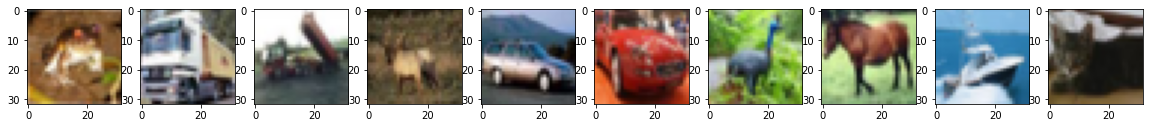

In [54]:
import torch
import random
import numpy as np
import time
start_time = time.time()

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
##

import torchvision.datasets
##

CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)
##

X_train = torch.FloatTensor(CIFAR_train.data) 
y_train = torch.LongTensor(CIFAR_train.targets) 
X_test = torch.FloatTensor(CIFAR_test.data) 
y_test = torch.LongTensor(CIFAR_test.targets)
##

len(y_train), len(y_test)
##
X_train.min(), X_train.max()
##
X_train /= 255.
X_test /= 255.
##
CIFAR_train.classes
##

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,2)) 
for i in range(10): 
    plt.subplot(1, 10, i+1) 
    plt.imshow(X_train[i]) 
    print(y_train[i], end=' ')
##
X_train.shape, y_train.shape
##

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)
##
X_train.shape

##


In [55]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)
        self.batch_drop1 = torch.nn.Dropout(p=0.10, inplace=False)
        self.batch_drop2 = torch.nn.Dropout2d(p=0.10, inplace=False)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.batch_drop2(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.batch_drop2(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.batch_drop2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        x = self.batch_drop2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.batch_drop1(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.batch_drop1(x)
        x = self.fc3(x)
        
        return x
net = CIFARNet()  

In [56]:
def train(X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=1e-5)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    train_loss_history = []
    train_batch_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(50):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            train_batch_loss_history.append(loss_value.tolist()) 

            optimizer.step()
            
        net.eval()
        with torch.no_grad(): 
             test_preds = net.forward(X_test)
            
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        train_loss = np.mean(train_batch_loss_history)
        train_loss_history.append(train_loss)


        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
        
        print(accuracy)
    print('---------------')    
    return test_accuracy_history, test_loss_history, train_loss_history

accuracies = {}
test_losses = {}
train_losses = {}
########

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
##


accuracies['cifar_net_drop'], test_losses['cifar_net_drop'], train_losses ['cifar_net_drop'] = \
    train(X_train, y_train, X_test, y_test)
###


tensor(0.6133)
tensor(0.6591)
tensor(0.6791)
tensor(0.6917)
tensor(0.6990)
tensor(0.7036)
tensor(0.7106)
tensor(0.7213)
tensor(0.7184)
tensor(0.7135)
tensor(0.7204)
tensor(0.7124)
tensor(0.7249)
tensor(0.7269)
tensor(0.7273)
tensor(0.7240)
tensor(0.7304)
tensor(0.7280)
tensor(0.7260)
tensor(0.7235)
tensor(0.7232)
tensor(0.7298)
tensor(0.7253)
tensor(0.7269)
tensor(0.7224)
tensor(0.7215)
tensor(0.7226)
tensor(0.7255)
tensor(0.7256)
tensor(0.7243)
tensor(0.7248)
tensor(0.7313)
tensor(0.7238)
tensor(0.7276)
tensor(0.7215)
tensor(0.7237)
tensor(0.7246)
tensor(0.7200)
tensor(0.7199)
tensor(0.7241)
tensor(0.7243)
tensor(0.7198)
tensor(0.7205)
tensor(0.7264)
tensor(0.7278)
tensor(0.7206)
tensor(0.7220)
tensor(0.7192)
tensor(0.7234)
tensor(0.7157)
---------------


In [57]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 192.60841155052185 seconds ---


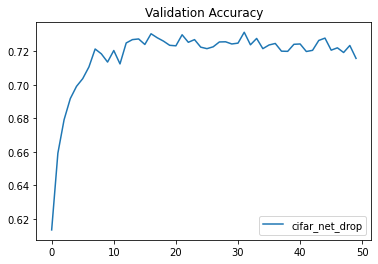

In [58]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');
###

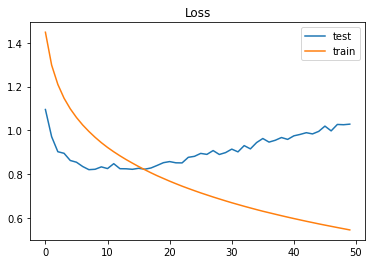

In [59]:
for experiment_id in test_losses.keys():
    plt.plot(test_losses[experiment_id], label='test')
    plt.plot(train_losses[experiment_id], label='train')
plt.legend()

plt.title('Loss');

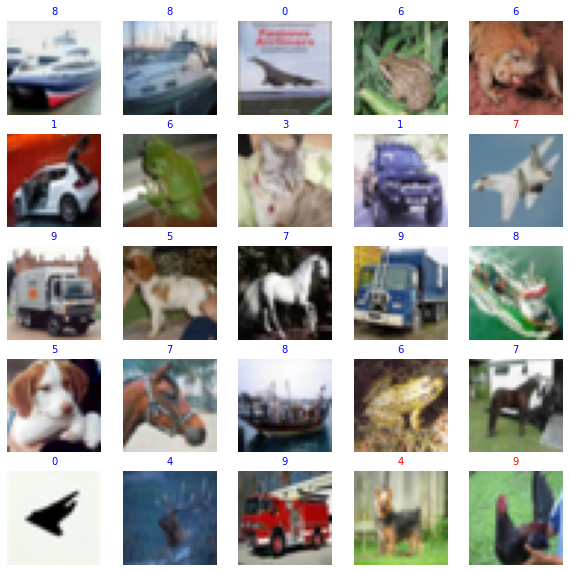

In [87]:
ROW_IMG = 5
N_ROWS = 5

fig = plt.figure(figsize=(10, 10))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')

    X_to_predict = X_test[index, :, :, :]
    X_to_predict = X_to_predict.unsqueeze(0)
    X_to_predict = X_to_predict.to(device)

    net.eval()
    with torch.no_grad():
        predicted_title = net.forward(X_to_predict).unsqueeze(0).cuda().detach().cpu().clone().numpy()
    
    title = np.argmax(predicted_title)

    X_to_predict = X_test[index, :, :, :]
    X_to_predict = X_to_predict.permute(1, 2, 0) 
    X_to_predict = X_to_predict.to('cpu')
    plt.imshow(X_to_predict)
    plt.title(title, fontsize=10, color='blue' if  title == y_test[index].item() else 'red')